# Mutual Information Estimators Comparison

## Steps:
1. Generate two synthetic datasets, one representing a vulnerable system (with high leakage) and another representing a non-vulnerable system (with no leakage).
2. Estimate the mutual information (MI) for both systems using multiple approaches.
3. Compare the estimated MI values with the ground truth and visualize the error for each approach.

In [1]:
import logging
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("pytorch").setLevel(logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)

In [2]:
# Cell 1: Setup and Imports
from autoqild.dataset_readers import SyntheticDatasetGenerator
from autoqild.mi_estimators.mi_estimator_classification import ClassficationMIEstimator
from autoqild.mi_estimators import MineMIEstimatorMSE, GMMMIEstimator, TabPFNMIEstimator
from autoqild.utilities import print_dictionary
from utils import setup_logging, setup_random_seed
from sklearn.model_selection import train_test_split

**Setting Up Experiment Logging and Random Seed:**

Initialize logging for the experiment, recording all key events in mi_estimation_comparison.log for tracking and debugging, using the utils.py file.

In [3]:
logger = setup_logging(log_path='mi_estimation_comparison.log')
logger = logging.getLogger("MI-Experiment")
setup_random_seed(42)
# Log some messages
logger.info('Logger initialized and ready.')
logger.info('Running the mutual information esitmation process...')

### Step 1: Generate and Visualizing Synthetic Datasets

Create two datasets:
- **Vulnerable Dataset:** High noise level leading to significant overlap between classes.
- **Non-Vulnerable Dataset:** Low noise level leading to clear separation between classes.

In [4]:
# Generating datasets with varying noise levels to simulate vulnerable and non-vulnerable systems.
n_classes = 2
n_features = 2
samples_per_class = 500
dataset_params = {'n_classes':n_classes, 'n_features': n_features, 'samples_per_class': samples_per_class,'random_state':42}
dataset_params['flip_y'] = 0.1
# Vulnerable dataset with high noise (leakage present)
generator_vulnerable = SyntheticDatasetGenerator(**dataset_params)
X_vulnerable, y_vulnerable = generator_vulnerable.generate_dataset()

dataset_params['flip_y'] = 1.0
# Non-vulnerable dataset with low noise (minimal leakage)
generator_non_vulnerable = SyntheticDatasetGenerator(**dataset_params)
X_non_vulnerable, y_non_vulnerable = generator_non_vulnerable.generate_dataset()


### Step 2: Visualize the Datasets

**Visualizing** the datasets using the scatter plots helps us see the differences in class separability for datasets simulating vulnerable and non-vulnerable systems. 

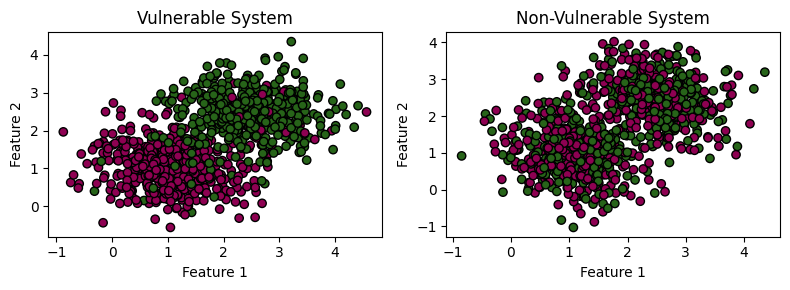

In [5]:
import matplotlib.pyplot as plt

def plot_datasets(X1, y1, title1, X2, y2, title2):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    # Plot the first dataset
    axes[0].scatter(X1[:, 0], X1[:, 1], c=y1, cmap='PiYG', edgecolor='k')
    axes[0].set_title(title1)
    axes[0].set_xlabel("Feature 1")
    axes[0].set_ylabel("Feature 2")

    # Plot the second dataset
    axes[1].scatter(X2[:, 0], X2[:, 1], c=y2, cmap='PiYG', edgecolor='k')
    axes[1].set_title(title2)
    axes[1].set_xlabel("Feature 1")
    axes[1].set_ylabel("Feature 2")

    plt.tight_layout()
    plt.show()

# Plotting both datasets side by side
plot_datasets(X_vulnerable, y_vulnerable, "Vulnerable System", X_non_vulnerable, y_non_vulnerable, "Non-Vulnerable System")

### Step 3. Estimating MI and Comparing to Ground Truth

Estimate the MI for each dataset using different approaches and compare them to the ground truth MI using the Bayes predictor log loss.

In [6]:
from sklearn.linear_model import LogisticRegression
learner_params = {'n_classes':n_classes, 'n_features':n_features}
classification_estimators = ["MidPointMI", "LogLossMI", "LogLossMIIsotonicRegression"]

def fit_estimate(estimator, x_train, x_test, y_train, y_test, method):
    estimator.fit(x_train, y_train)
    mi = estimator.estimate_mi(x_test, y_test, method=method)
    return mi

In [7]:
# Splitting the non-vulnerable dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X_non_vulnerable, y_non_vulnerable, test_size=0.3, random_state=42, 
                                                    stratify=y_non_vulnerable)
non_vulnerable_scores = {}

model = TabPFNMIEstimator(**learner_params)
mine_estimator = MineMIEstimatorMSE(**learner_params)
gmm_estimator = GMMMIEstimator(**learner_params)
ground_truth_mi_non_vulnerable = generator_non_vulnerable.get_bayes_mi()
for method in classification_estimators:
    non_vulnerable_scores[method] = fit_estimate(model, x_train, x_test, y_train, y_test, method)
non_vulnerable_scores['GMM Baseline'] = fit_estimate(gmm_estimator, x_train, x_test, y_train, y_test, '')
non_vulnerable_scores['MINE Baseline'] = fit_estimate(mine_estimator, x_train, x_test, y_train, y_test, '')
print(f"{print_dictionary(non_vulnerable_scores)} Ground-truth MI {ground_truth_mi_non_vulnerable}")

iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.26it/s]


  MidPointMI => 0.07272629655051024
LogLossMI => 0.0007286310195922851
LogLossMIIsotonicRegression => 0.0007286310195922851
GMM Baseline => 0.0
MINE Baseline => 0.0016100859502330422 Ground-truth MI 0.0


In [8]:
vulnerable_scores = {}

x_train, x_test, y_train, y_test = train_test_split(X_vulnerable, y_vulnerable, test_size=0.5, random_state=42, stratify=y_vulnerable)

model = ClassficationMIEstimator(**learner_params)
mine_estimator = MineMIEstimatorMSE(**learner_params)
gmm_estimator = GMMMIEstimator(**learner_params)
ground_truth_mi_vulnerable = generator_vulnerable.get_bayes_mi()
for method in classification_estimators:
    vulnerable_scores[method] = fit_estimate(model, x_train, x_test, y_train, y_test, method)
vulnerable_scores['GMM Baseline'] = fit_estimate(gmm_estimator, x_train, x_test, y_train, y_test, '')
vulnerable_scores['MINE Baseline'] = fit_estimate(mine_estimator, x_train, x_test, y_train, y_test, '')
print(f"{print_dictionary(vulnerable_scores)} Ground-truth MI {ground_truth_mi_vulnerable}")

iteration: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.29it/s]


  MidPointMI => 0.6421495124462486
LogLossMI => 0.6427117603412165
LogLossMIIsotonicRegression => 0.6307350731910841
GMM Baseline => 0.554790656705828
MINE Baseline => 0.009389414452016354 Ground-truth MI 0.6253253757356205


### Step 4:Visualizing the Results
The bar plots for the vulnerable and non-vulnerable datasets will show the absolute error between MI estimated by each approach and ground truth value.

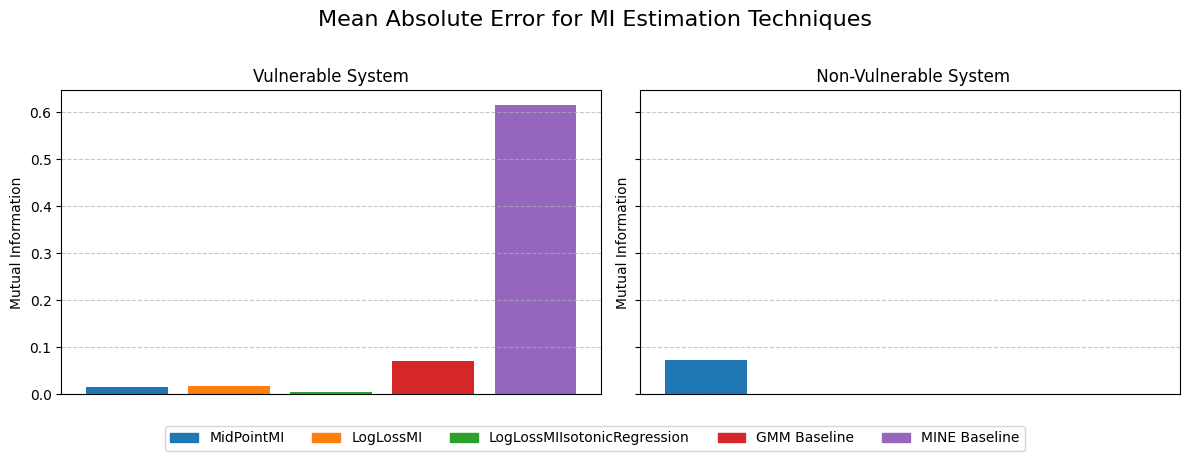

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot MI scores with error bars
def plot_mi_scores_with_error_bars(ax, estimated_scores, ground_truth_mi, title):
    methods = list(estimated_scores.keys())
    mi_values = list(estimated_scores.values())
    errors = [abs(mi - ground_truth_mi) for mi in mi_values]  # Calculate errors based on the difference from ground truth

    y_pos = np.arange(len(methods))
    colors = plt.get_cmap("tab10").colors  # Get the 'tab10' colormap

    bars = ax.bar(y_pos, errors, color=[colors[i % 10] for i in range(len(methods))], capsize=5, align='center')
    ax.set_xticks([])
    ax.set_ylabel('Mutual Information')
    ax.set_title(title)
    
    # Adding grid and customizing the appearance
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Adding color-coded legends for each method
    for i, bar in enumerate(bars):
        bar.set_label(methods[i])
    

# Plotting side-by-side subplots for the vulnerable and non-vulnerable datasets
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)  # 1 row, 2 columns, slightly wider figure size

# Plotting MI estimations for the vulnerable dataset
plot_mi_scores_with_error_bars(axs[0], vulnerable_scores, ground_truth_mi_vulnerable, "Vulnerable System")

# Plotting MI estimations for the non-vulnerable dataset
plot_mi_scores_with_error_bars(axs[1], non_vulnerable_scores, ground_truth_mi_non_vulnerable, " Non-Vulnerable System")

colors = plt.get_cmap("tab10").colors  # Get the 'tab10' colormap
legend_labels = list(vulnerable_scores.keys())  # Assuming the methods are the same for both datasets
handles = [plt.Rectangle((0,0),1,1, color=colors[i % 10]) for i in range(len(legend_labels))] + [plt.Line2D([0], [0], color='red', linestyle='--')]
fig.legend(handles, legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.10), ncol=6)
plt.suptitle("Mean Absolute Error for MI Estimation Techniques", fontsize=16, y=1.02)
# Adjust layout for better spacing
plt.tight_layout()
plt.show()